In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer, Conv2D,UpSampling2D , Flatten,MaxPooling2D,Conv2DTranspose
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from PIL import Image
import random
from math import ceil

2022-03-10 14:53:34.157315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 14:53:34.157337: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
os.chdir('/home/thiago/Documents/Projects/CERTH_ImageBlurDataset/TrainingSet')
os.curdir   
os.listdir()    

['Artificially-Blurred', 'Undistorted', 'Naturally-Blurred']

In [4]:
init_size=100
folders=os.listdir()
filelist=[]
fake_data=[]
real_data=[]
for i in folders[0:3]:
    files=os.listdir(i)
    for j in files:
        im = Image.open(i+'/'+j) 
        width = 50   
        height = 50 
        im5 = im.resize((width, height), Image.ANTIALIAS)   
        x=np.asarray(im5)  
        x =(x-x.mean())/255.0
        fake_data.append(x)

In [5]:
for i in folders[2:]:
    files1=os.listdir(i)
    for j in files1:
        im = Image.open(i+'/'+j) 
        width = 50
        height = 50
        im5 = im.resize((width, height), Image.LANCZOS)  
        x=np.asarray(im5)
        x =(x-x.mean())/255.0
        real_data.append(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


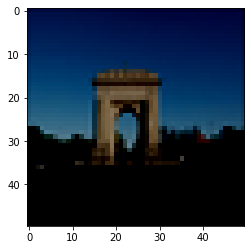

In [6]:
fake_data= np.asarray(fake_data)     
plt.imshow(fake_data[70], interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


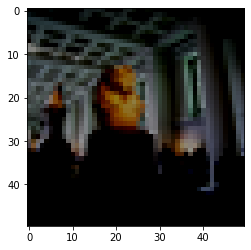

In [7]:
real_data= np.asarray(real_data)      
plt.imshow(real_data[50], interpolation='nearest')

In [8]:
def adam_optimizer():
    return Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [9]:
def create_generator():
    generator=tf.keras.models.Sequential()
    generator.add(InputLayer(input_shape=(50,100,100)))
    
    generator.add(Conv2D(32, (2, 2), activation='tanh', padding='same', strides=2))
    generator.add(layers.LeakyReLU(0.6))
    generator.add(layers.Dropout(0.4))
    
    generator.add(Conv2D(32, (2, 2), activation='tanh', padding='same'))
    generator.add(layers.LeakyReLU(0.3))
    generator.add(layers.Dropout(0.2))
    
    generator.add(Conv2D(32, (3, 3), activation='tanh', padding='same'))
    generator.add(UpSampling2D((2, 1)))
    generator.add(Conv2D(3, (5, 5), activation='tanh', padding='same'))
    
    generator.add(layers.Dense(units=3, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 50, 32)        12832     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25, 50, 32)        0         
                                                                 
 dropout (Dropout)           (None, 25, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 50, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 25, 50, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 25, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 50, 32)        9

2022-03-10 14:56:58.854809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-10 14:56:58.854845: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-10 14:56:58.854870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Thiago-PC): /proc/driver/nvidia/version does not exist
2022-03-10 14:56:58.855049: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/thiago/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument

                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 3)         2403      
                                                                 
 dense (Dense)               (None, 50, 50, 3)         12        
                                                                 
Total params: 28,623
Trainable params: 28,623
Non-trainable params: 0
_________________________________________________________________


In [10]:
def create_discriminator():
    discriminator=tf.keras.models.Sequential()
    discriminator.add(InputLayer(input_shape=(50,50,3)))
    
    discriminator.add(Conv2D(10, (2, 2), activation='tanh', padding='same', strides=2))
    discriminator.add(layers.Dense(units=100))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))
    
    discriminator.add(Conv2D(10, (3, 3), activation='tanh', padding='same', strides=2))
    discriminator.add(layers.Dense(units=50))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))
    
    discriminator.add(Conv2D(10, (3, 3), activation='tanh', padding='same', strides=2))
    discriminator.add(layers.Dense(units=25))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))
    
    discriminator.add(Conv2D(1, (4, 4), activation='sigmoid', padding='same', strides=3))  
    #discriminator.add(Conv2D(1, (4, 4), activation='tanh', padding='same')) 
    discriminator.add(MaxPooling2D(pool_size = (2, 3)))
    #discriminator.add(Conv2DTranspose(1, (2,2), strides=(2,2)))
    discriminator.add(Flatten())
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 10)        130       
                                                                 
 dense_1 (Dense)             (None, 25, 25, 100)       1100      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 25, 25, 100)       0         
                                                                 
 dropout_2 (Dropout)         (None, 25, 25, 100)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 10)        9010      
                                                                 
 dense_2 (Dense)             (None, 13, 13, 50)        550       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 13, 13, 50)       

In [11]:
def create_gan(discriminator, generator):
    d.trainable=False    
    gan_input = Input(shape=(None,100,100))   
    x = g(gan_input)
    gan_output= d(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [12]:
gan = create_gan(d,g)
gan.summary()  


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 100, 100)]  0         
                                                                 
 sequential (Sequential)     (None, 50, 50, 3)         28623     
                                                                 
 sequential_1 (Sequential)   (None, 1)                 15976     
                                                                 
Total params: 44,599
Trainable params: 28,623
Non-trainable params: 15,976
_________________________________________________________________


In [18]:
i=0  
epoch_num=1   
batches=2    
for epoch in range(epoch_num):
    i=i+1
    for index in range(batches):
        # [Batch Preparation]
        print(index)
        noise= np.random.normal(0,1, [batches,50,100,100])
        noise = tf.cast(noise, tf.float32)
    
        # Generate fake inputs
        gen_images = g.predict(x=noise,steps=None)
        y_gen = np.ones(gen_images.shape[0])  
        ran_real_image =real_data[np.random.randint(low=0,high=real_data.shape[0],size=batches)] #get random set of real images
        ran_fake_image =real_data[np.random.randint(low=0,high=real_data.shape[0],size=batches)]#get random set of fake images

0
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


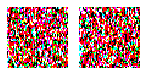

In [19]:
dim=(20,20)
figsize=(20,20)    
plt.figure(figsize=figsize)
for i in range(gen_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(gen_images[i]*256, interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()    
    os.chdir('/home/thiago/Documents/Projects/CERTH_ImageBlurDataset/output')
    plt.savefig('actual'+str(i)+'.png') 

In [20]:
result = Image.fromarray((gen_images[1]*256).astype(np.uint8))   
os.chdir('/home/thiago/Documents/Projects/CERTH_ImageBlurDataset/output')      
result.save('actual.png')      
a=(gen_images[1]*255.0).astype(np.uint8)